In [286]:
# @title Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [287]:
# @title Function to Scale Down the Input Images
def resize_img(image, target_width=200, target_height=200):
    """
    Scale down the input image to fit within a specific size while maintaining aspect ratio.
    """
    original_height, original_width = image.shape[:2]

    # Calculate scaling factors to fit within target dimensions
    width_scale = target_width / original_width
    height_scale = target_height / original_height
    scale_factor = min(width_scale, height_scale)

    # Use the smaller scale factor to fit within target
    new_width = int(original_width * scale_factor)
    new_height = int(original_height * scale_factor)

    # Resize the image
    scaled_image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return scaled_image

In [288]:
# @title Step 1: Load the Color Image and Apply Partial Contrast Stretching
def load_and_preprocess_image(scaled_image):

    stretched_image = np.zeros_like(scaled_image)
    p2, p98 = np.percentile(scaled_image, (2, 98))
    stretched_image[:, :] = np.clip(((scaled_image[:, :] - p2) * 255 / (p98 - p2)), 0, 255).astype(np.uint8)

    return stretched_image

In [289]:
# @title Step 2: Calculate Potentials for Each Pixel
def calculate_potential(image, ra=20):
    n = image.size
    potentials = np.zeros(n)

    for i in range(n):
        xi = image.flat[i]
        potentials[i] = np.sum(np.exp(-4 * (xi - image.ravel())**2 / ra**2))

    return potentials

In [202]:
# @title Step 3: Find Initial Cluster Centers (Subtractive Clustering)
def update_potential(potentials, p1, x1, rb, image):
    n = image.size
    updated_potentials = potentials - p1 * np.exp(-4 * (image.ravel() - x1)**2 / rb**2)
    return updated_potentials

def subtractive_clustering(image, k=30, ra=20, rb=10):
    potentials = calculate_potential(image, ra)
    cluster_centers = []

    for _ in range(k):
        max_index = np.argmax(potentials)
        max_potential = potentials[max_index]
        if max_potential == 0 :
          break
        cluster_centers.append(image.flat[max_index])

        # Update potentials
        potentials = update_potential(potentials, max_potential, cluster_centers[-1], rb, image)

    return cluster_centers

In [172]:
# @title Step 4: K-means Clustering with Initial Centers
def kmeans_clustering(image, initial_centers,  max_iters=100):
  pixels = image.flatten().astype(float)
  k = len(initial_centers)

  # Initialize cluster centers
  centers = np.array(initial_centers)
  labels = np.zeros(pixels.shape, dtype=int)
  prev_centers = np.zeros(centers.shape)
  labels = np.zeros(pixels.shape, dtype=np.int32)

  for _ in range(100):
      # Step 1: Assign labels based on closest center
      for i, pixel in enumerate(pixels):
          distances = np.abs(centers - pixel)
          labels[i] = np.argmin(distances)      # Assign label based on closest center

      # Step 2: Update centers
      new_centers = np.zeros_like(centers)
      for j in range(k):
          # Compute the mean of pixels assigned to the current center
          if np.any(labels == j):  # Check if there are pixels assigned to this cluster
              new_centers[j] = pixels[labels == j].mean()  # Calculate mean
          else:
              new_centers[j] = centers[j]  # Keep the old center if no pixels assigned

      # Check for convergence (if centers do not change)
      if np.all(centers == new_centers):
          break

      centers = new_centers  # Update centers for the next iteration

  # Create segmented image
  segmented_image = centers[labels.flatten()]

  # Reshape segmented image back to original image shape
  segmented_image = segmented_image.reshape(image.shape)
  return segmented_image

In [173]:
# @title Step 5: Apply Median Filter to Smooth the Segmented Image
def apply_median_filter(segmented_image, kernel_size=3):
    smoothed_image = cv2.medianBlur(segmented_image, kernel_size)
    return smoothed_image

In [174]:
# @title Step 6: Calculate RMSE and PSNR
def calculate_rmse_color(reference_image, segmented_image):
    if reference_image.shape != segmented_image.shape:
        raise ValueError("Images must have the same dimensions for RMSE calculation.")

    rmse_per_channel = []
    for i in range(3):
        rmse = np.sqrt(np.mean((reference_image[:, :, i] - segmented_image[:, :, i]) ** 2))
        rmse_per_channel.append(rmse)

    avg_rmse = np.mean(rmse_per_channel)
    return avg_rmse

def calculate_psnr_color(reference_image, segmented_image):
    rmse = calculate_rmse_color(reference_image, segmented_image)
    max_pixel_value = 255.0
    psnr = 10 * np.log10((max_pixel_value ** 2) / (rmse ** 2))
    return psnr

In [290]:
# @title Main function to execute the algorithm
def segment_image(image_path, ra=20, rb=10, width=100, height=100):

    # Scale down the image
    scaled_image = resize_img(image_path, target_width=width, target_height=height)

    # Preprocess the scaled image
    preprocessed_image = load_and_preprocess_image(scaled_image)

    # Calculate potentials
    potentials = calculate_potential(preprocessed_image, ra=ra)

    # Find initial centers
    initial_centers = subtractive_clustering(preprocessed_image, ra=ra, rb=rb)

    # Apply K-means clustering
    segmented_image = kmeans_clustering(preprocessed_image, initial_centers)

    # Apply median filter
    smoothed_image = apply_median_filter(segmented_image)

    return preprocessed_image, smoothed_image

In [291]:
# @title Testing for Different Images
def testing(image_path, ra=20, rb=10, width=150, height=150):
  # Split the image into R, G, B channels
  image = cv2.imread(image_path)
  b_channel, g_channel, r_channel = cv2.split(image)

  original_b , segmented_b = segment_image(b_channel, ra=ra, rb=rb, width=width, height=height)
  original_g , segmented_g = segment_image(g_channel, ra=ra, rb=rb, width=width, height=height)
  original_r , segmented_r = segment_image(r_channel, ra=ra, rb=rb, width=width, height=height)

  original = cv2.merge((original_b, original_g, original_r))
  segmented_image = cv2.merge((segmented_b, segmented_g, segmented_r))

  plt.figure(figsize=(12, 3))
  plt.subplot(1, 2, 1)
  plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
  plt.title("Original Image")
  plt.subplot(1, 2, 2)
  plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
  plt.title("Segmented Image")
  # plt.suptitle(f"ra = {ra}")
  plt.show()

  print("RMSE = ", calculate_rmse_color(original,segmented_image), " PSNR = ", calculate_psnr_color(original,segmented_image))

# RESULTS

### Different rb :

CPU times: user 47.3 s, sys: 73.7 ms, total: 47.4 s
Wall time: 51 s


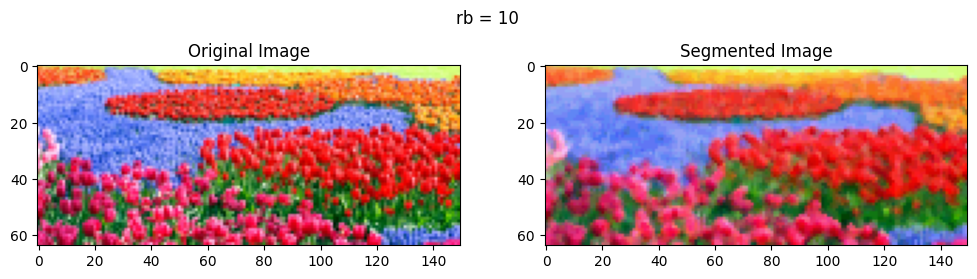

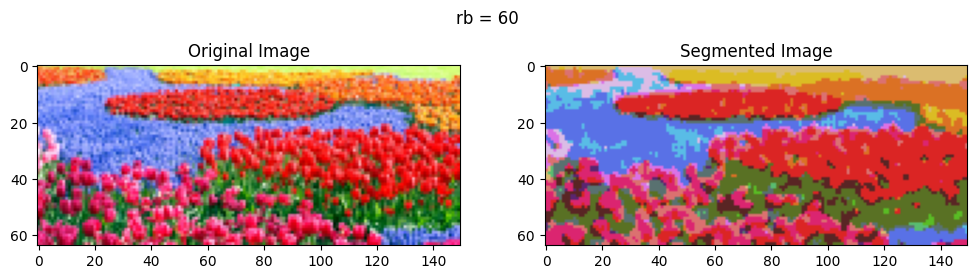

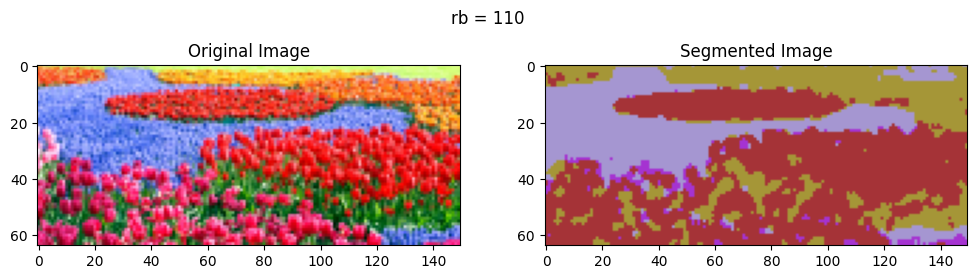

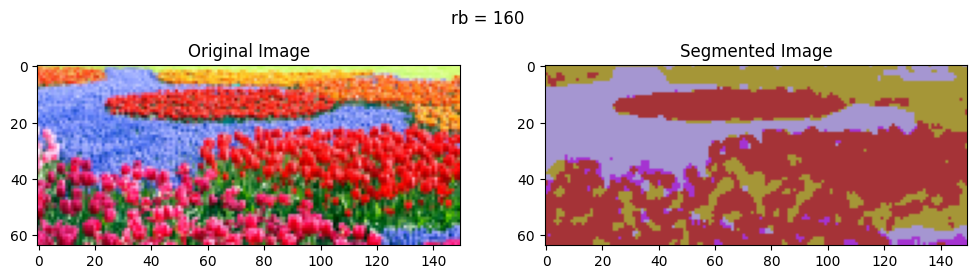

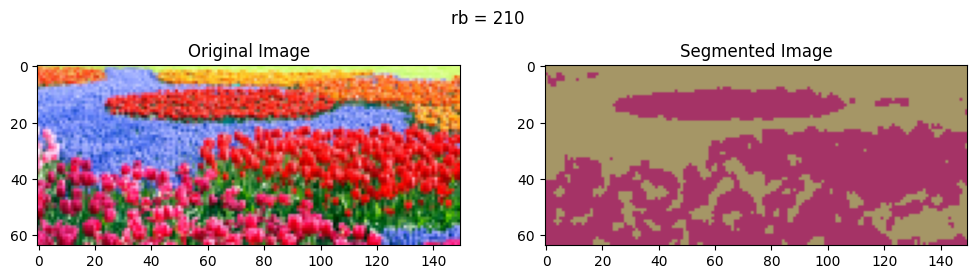

In [240]:
%%time
for rb in range(10,220,50):
  testing(image_path = 'tulip.jpg', rb=rb)

### Different ra :

CPU times: user 16.9 s, sys: 38.4 ms, total: 17 s
Wall time: 17.1 s


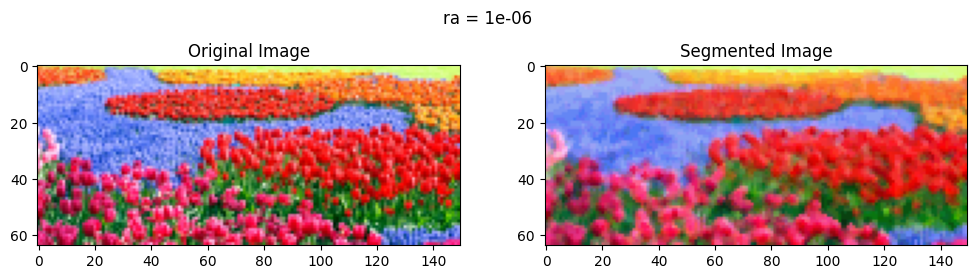

In [245]:
%%time
testing(image_path = 'tulip.jpg', ra=0.000001)

CPU times: user 23.9 s, sys: 65.9 ms, total: 24 s
Wall time: 25.6 s


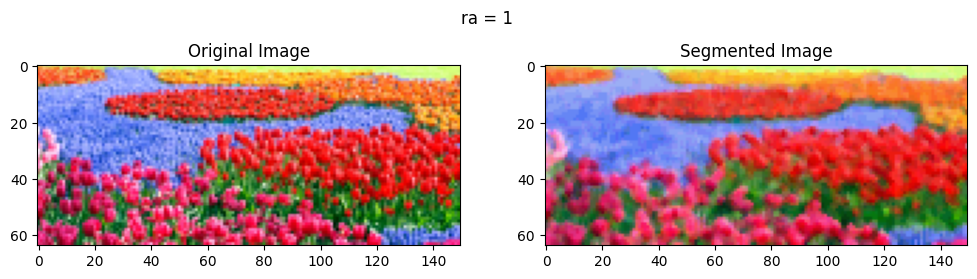

In [246]:
%%time
testing(image_path = 'tulip.jpg', ra=1)

CPU times: user 14.4 s, sys: 34.4 ms, total: 14.4 s
Wall time: 15 s


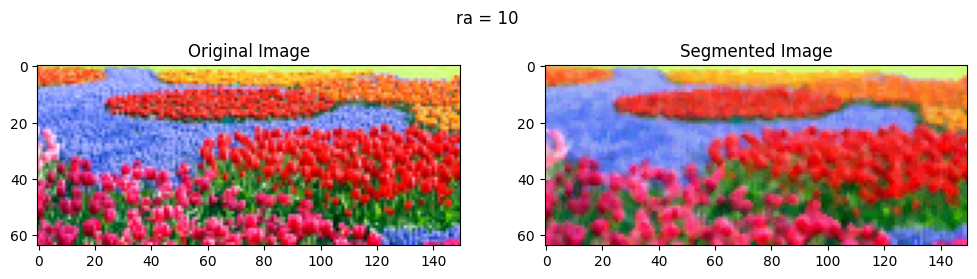

In [247]:
%%time
testing(image_path = 'tulip.jpg', ra=10)

CPU times: user 12.9 s, sys: 26.5 ms, total: 13 s
Wall time: 13.1 s


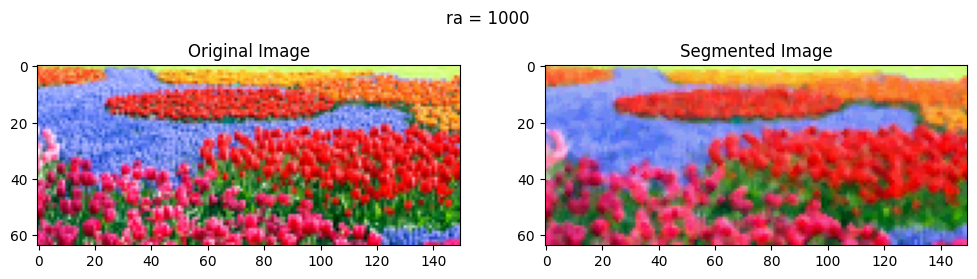

In [248]:
%%time
testing(image_path = 'tulip.jpg', ra=1000)

CPU times: user 11.6 s, sys: 29.2 ms, total: 11.6 s
Wall time: 11.8 s


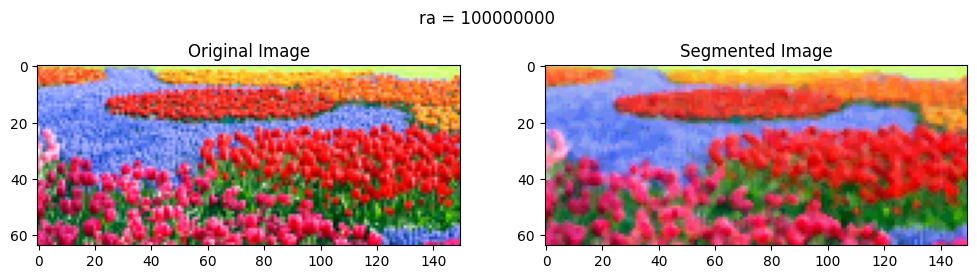

In [249]:
%%time
testing(image_path = 'tulip.jpg', ra=100000000)

### Different Images :

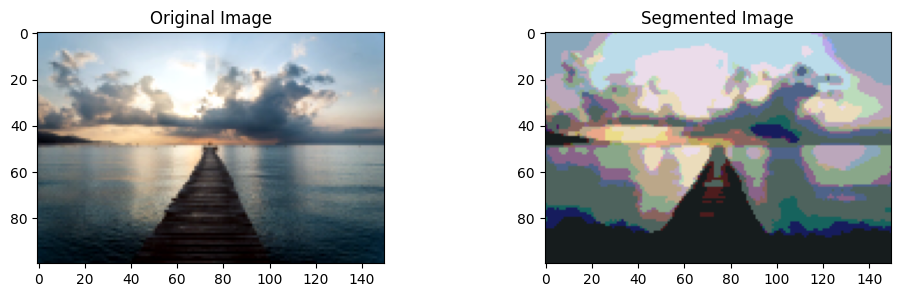

RMSE =  9.421332037852673  PSNR =  28.64855740889011


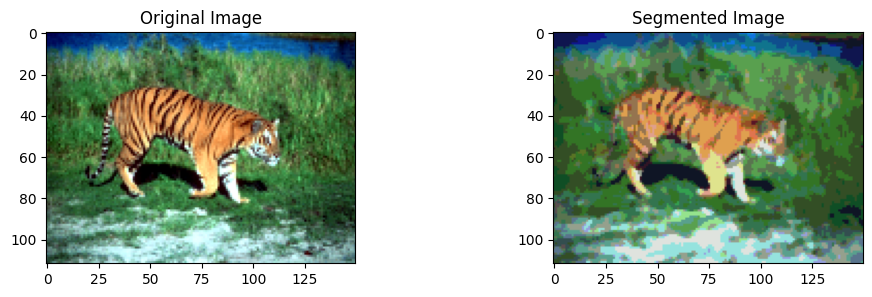

RMSE =  9.380606506299118  PSNR =  28.68618523379807


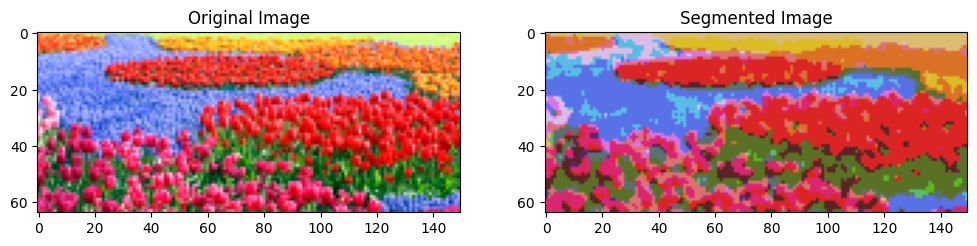

RMSE =  10.027569619154281  PSNR =  28.106889891223304


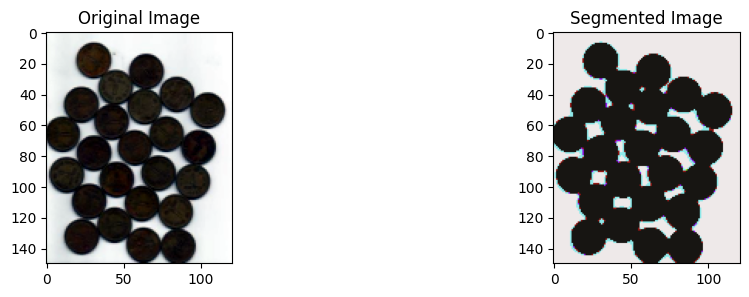

RMSE =  8.783282311064573  PSNR =  29.2576667684672


In [304]:
testing('bridge.jpg',rb=30)
testing('tiger.png',rb=30)
testing('tulip.jpg',rb=60)
testing('water_coins.png',rb=60)

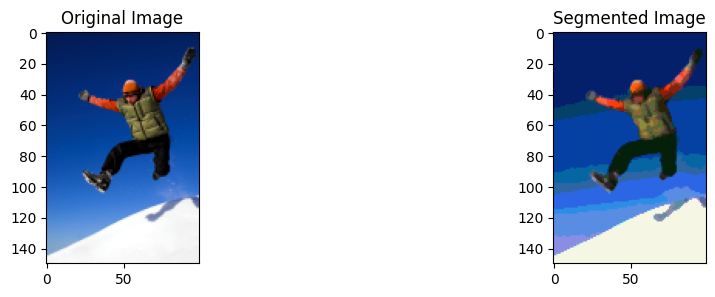

RMSE =  8.090871607002278  PSNR =  29.970897419396493


In [306]:
testing('jump.png',rb=30)

# Compairing with Traditional KMeans

In [292]:
import cv2
from sklearn.cluster import KMeans

def elbow(image_path, K=5):
  # Load the image
  image = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Scale down the image
  scaled_image = resize_img(image_rgb, target_width=200, target_height=200)

  # Preprocess the scaled image
  preprocessed_image = load_and_preprocess_image(scaled_image)

  # Reshape the image to a 2D array of pixels and 3 color values (RGB)
  pixels = preprocessed_image.reshape(-1, 3)

  # Try different values of K and calculate WCSS
  wcss = []
  K_values = range(1, 11)
  for K in K_values:
      kmeans = KMeans(n_clusters=K, random_state=0)
      kmeans.fit(pixels)
      wcss.append(kmeans.inertia_)  # Inertia is the WCSS for the given K

  # Plot the Elbow graph
  plt.plot(K_values, wcss, marker='o')
  plt.xlabel('Number of clusters (K)')
  plt.ylabel('WCSS')
  plt.title('Elbow Method for Optimal K')
  plt.show()

def KMeans_(image_path, K=5):
  # Load the image
  image = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Scale down the image
  scaled_image = resize_img(image_rgb, target_width=200, target_height=200)

  # Preprocess the scaled image
  preprocessed_image = load_and_preprocess_image(scaled_image)

  # Reshape the image to a 2D array of pixels and 3 color values (RGB)
  pixels = preprocessed_image.reshape(-1, 3)

  # Define the number of clusters (e.g., 3 for a simple segmentation)
  kmeans = KMeans(n_clusters=K,init='k-means++', random_state=0).fit(pixels)

  # Replace each pixel value with its cluster centroid value
  segmented_pixels = kmeans.cluster_centers_[kmeans.labels_]
  segmented_image = segmented_pixels.reshape(preprocessed_image.shape).astype(np.uint8)

  # Display the original and segmented images
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(preprocessed_image)
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(segmented_image)
  plt.title('Segmented Image')
  plt.axis('off')

  plt.show()
  print("RMSE = ", calculate_rmse_color(preprocessed_image,segmented_image), " PSNR = ", calculate_psnr_color(preprocessed_image,segmented_image))

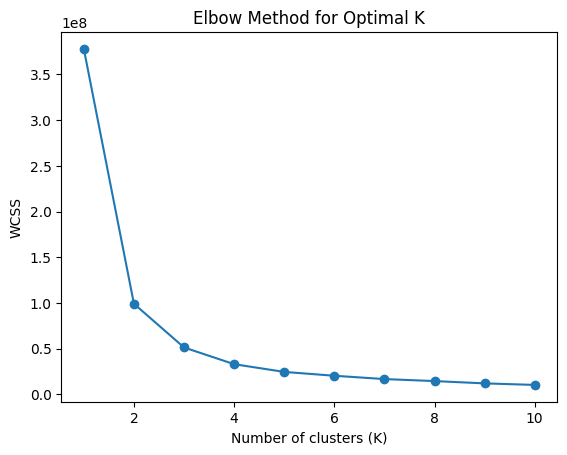

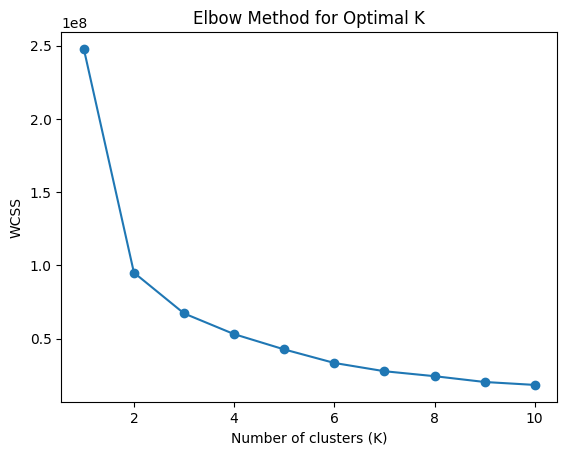

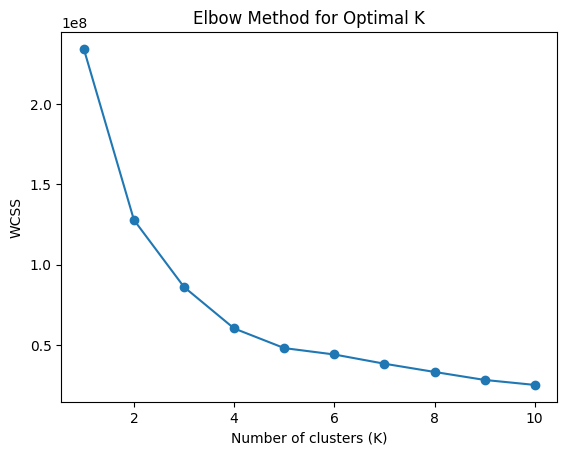

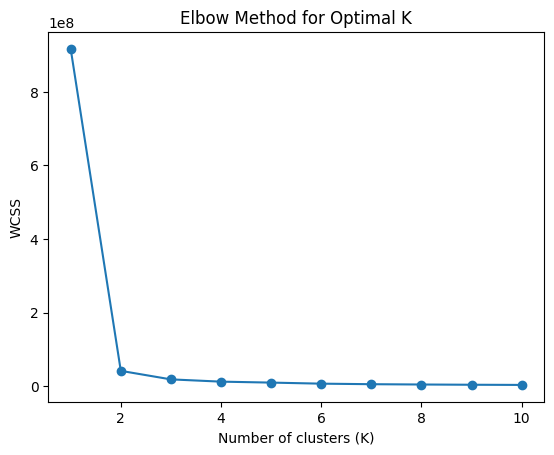

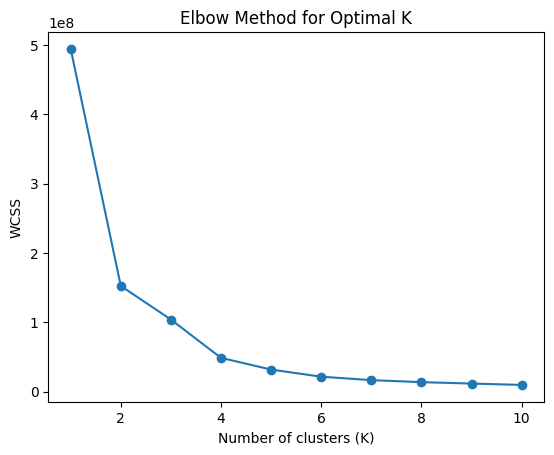

In [284]:
elbow('bridge.jpg')
elbow('tiger.png')
elbow('tulip.jpg')
elbow('water_coins.png')
elbow('jump.png')

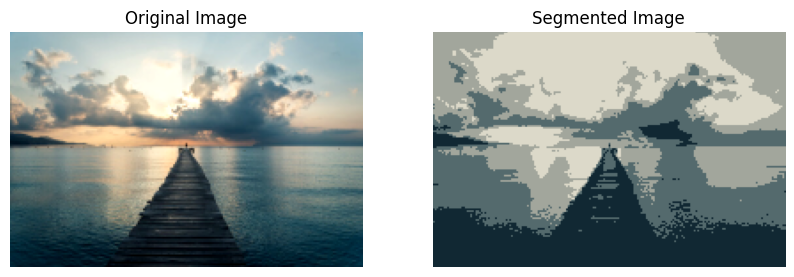

RMSE =  9.635896077243066  PSNR =  28.452961458623015


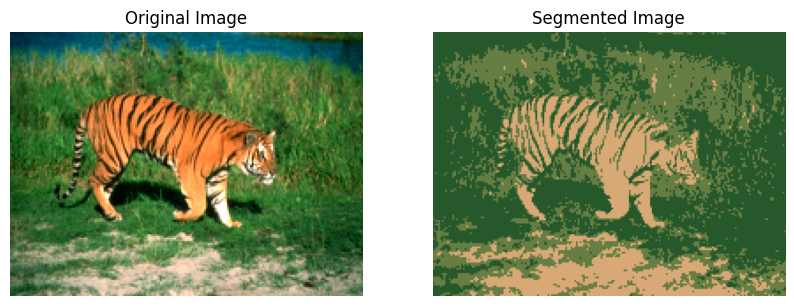

RMSE =  9.708759900378768  PSNR =  28.387528388102346


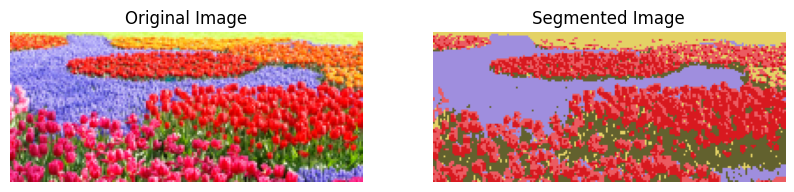

RMSE =  10.049291471874982  PSNR =  28.088094753056012


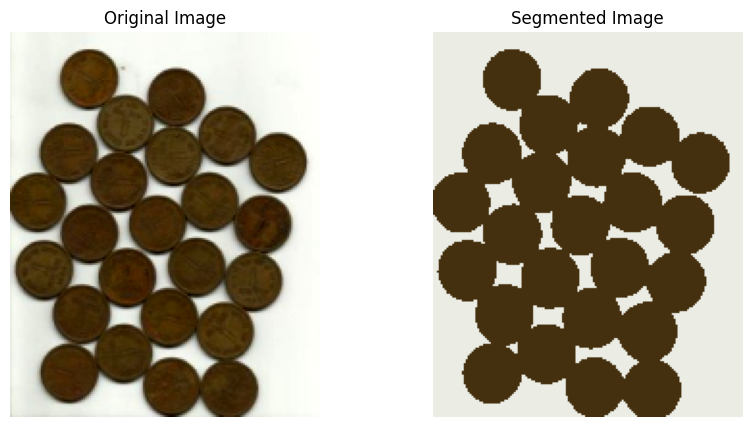

RMSE =  8.882649402971502  PSNR =  29.159953190680206


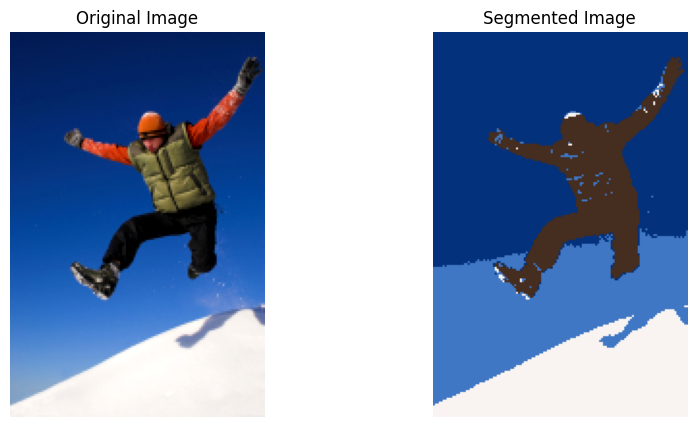

RMSE =  8.51765842876093  PSNR =  29.524399204510665


In [285]:
KMeans_('bridge.jpg',K=4)
KMeans_('tiger.png',K=3)
KMeans_('tulip.jpg',K=5)
KMeans_('water_coins.png',K=2)
KMeans_('jump.png',K=4)

In [301]:
# @title Compairing
def compare(image_path, K=5, ra=20, rb=10, width=150, height=150):
  # Split the image into R, G, B channels
  image = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Scale down the image
  scaled_image = resize_img(image_rgb, target_width=200, target_height=200)

  # Preprocess the scaled image
  preprocessed_image = load_and_preprocess_image(scaled_image)

  # Reshape the image to a 2D array of pixels and 3 color values (RGB)
  pixels = preprocessed_image.reshape(-1, 3)

  # Define the number of clusters (e.g., 3 for a simple segmentation)
  kmeans = KMeans(n_clusters=K,init='k-means++', random_state=0).fit(pixels)

  # Replace each pixel value with its cluster centroid value
  segmented_pixels = kmeans.cluster_centers_[kmeans.labels_]
  segmented_image_ = segmented_pixels.reshape(preprocessed_image.shape).astype(np.uint8)


  b_channel, g_channel, r_channel = cv2.split(image)

  original_b , segmented_b = segment_image(b_channel, ra=ra, rb=rb, width=width, height=height)
  original_g , segmented_g = segment_image(g_channel, ra=ra, rb=rb, width=width, height=height)
  original_r , segmented_r = segment_image(r_channel, ra=ra, rb=rb, width=width, height=height)

  original = cv2.merge((original_b, original_g, original_r))
  segmented_image = cv2.merge((segmented_b, segmented_g, segmented_r))


  # Display the original and segmented images
  plt.figure(figsize=(16, 6))
  plt.subplot(1, 3, 1)
  plt.imshow(preprocessed_image)
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(segmented_image_)
  plt.title('KMeans++ Algorithm')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
  plt.title('Proposed Algorithm')
  plt.axis('off')

  plt.show()

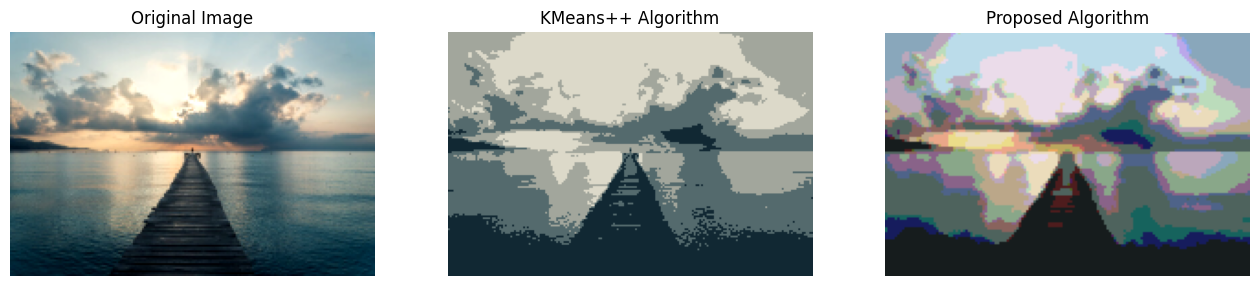

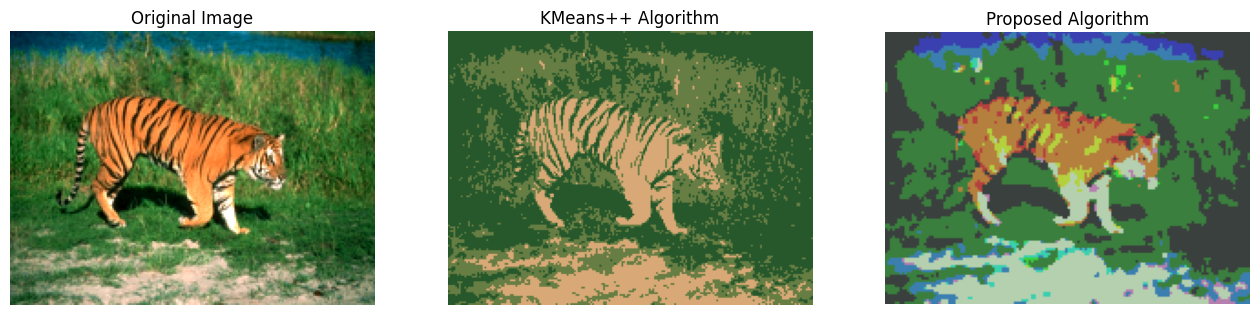

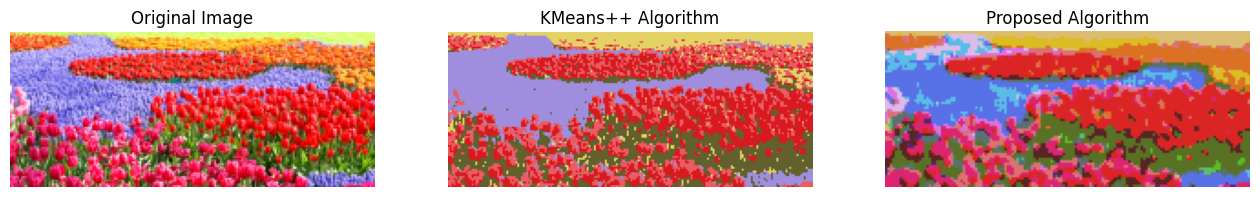

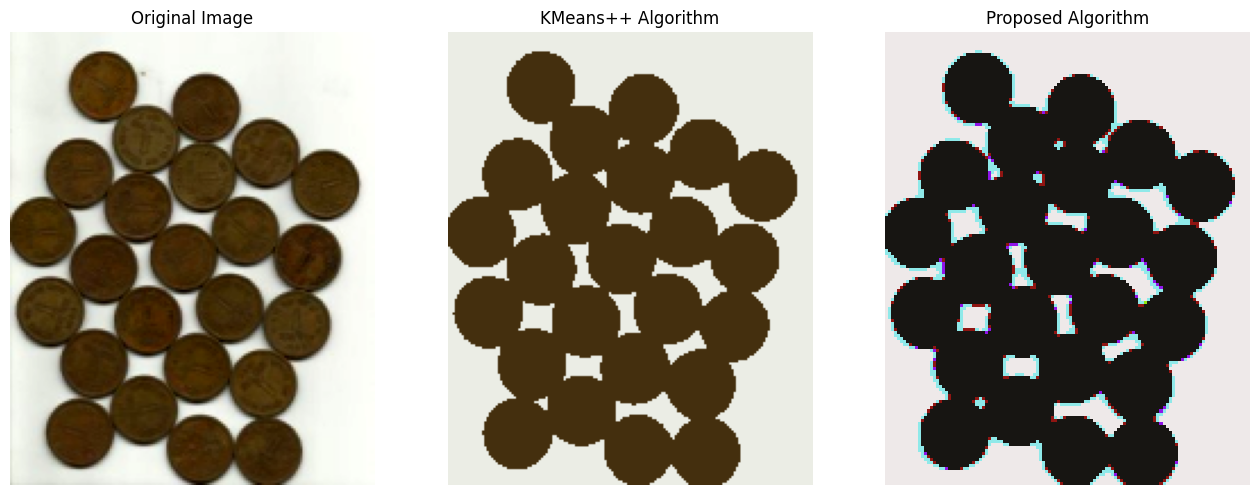

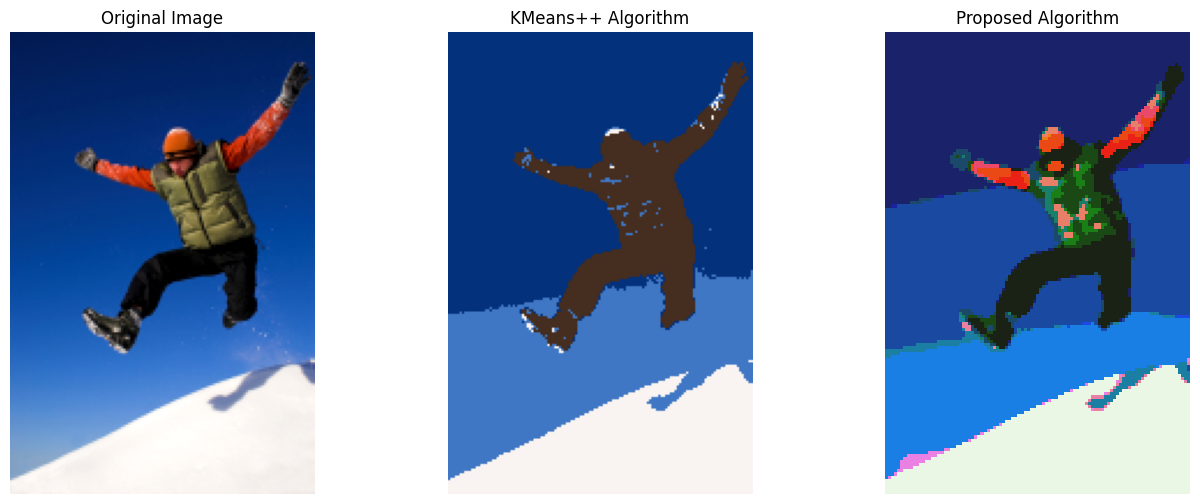

In [302]:
compare('bridge.jpg',rb=30, K=4)
compare('tiger.png',rb=60, K=3)
compare('tulip.jpg',rb=60, K=5)
compare('water_coins.png',rb=60, K=2)
compare('jump.png',rb=40, K=4)

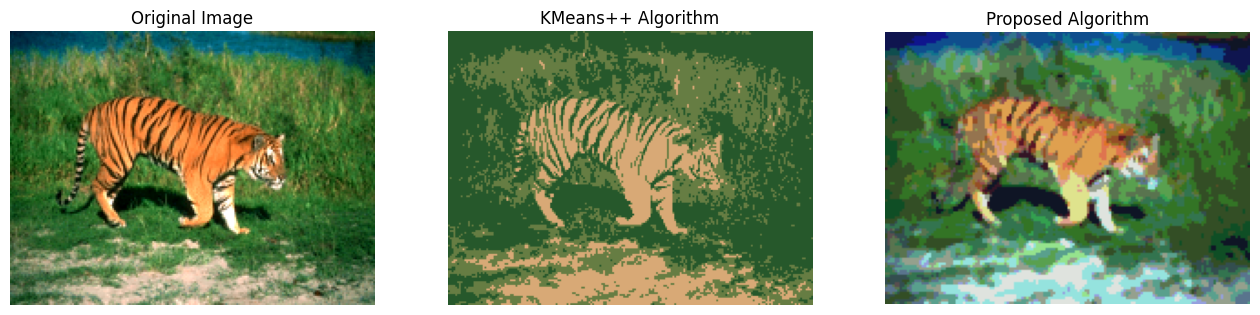

In [303]:
compare('tiger.png',rb=30, K=3)